Dans cette partie, nous allons afficher les éoliennes sur la carte de France

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("eolien.csv", sep=";")

In [3]:
df.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,type_feu_desc,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,NaN,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaN,NaN,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN


On retrouve ici l'emplacement de l'éolienne, ainsi que la longueur des pales, ce qui sont les informations qui nous intéressent dans un premier temps. 

On convertit la colonnes date_maj en date interprétable plus facilement

In [4]:
import datetime

df.date_mise_en_service = pd.to_datetime((df.date_mise_en_service))

In [5]:
df.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,type_feu_desc,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,NaN,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaN,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN


In [6]:
df.count()

id_aerogenerateur        7483
id_parc                  7483
code_insee               7483
nom_commune              7483
code_dept                7483
code_reg                 7483
puissance                7483
hauteur_totale           7483
hauteur_mat_nacelle      7483
diametre_rotor           7483
cote_ngf                 7483
periode_allumage_lib     7483
periode_allumage_desc       0
type_feu_lib             7483
type_feu_desc               0
date_mise_en_service     4331
constructeur             7483
reference_modele         7483
x_aerogenerateur         7483
y_aerogenerateur         7483
epsg                     7483
libelle                  7483
date_maj                 7483
nom_eolienne              347
dtype: int64

Il y a 7483 éoliennes dans ce tableau. 
L'autre donnée intéressante est que nous n'avons que 4331 date de mise en service soit 58% de date de mise en service. 

On convertit cela pour avoir des données exploitables par geopandas

In [9]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 15.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 18.4 MB/s eta 0:00:00


In [11]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 18.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.13
    Uninstalling botocore-1.29.13:
      Successfully uninstalled botocore-1.29.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.26.13 requires botocore<1.30.0,>=1.29.13, but you have botocore 1.23.26 which is incompatible.


In [12]:
from shapely.geometry import Point
geometrie = [Point(xy) for xy in zip(df.x_aerogenerateur,df.y_aerogenerateur)] # colonnes du DataFrame résultants
caract_eoliennes = gpd.GeoDataFrame(df,geometry=geometrie)

In [13]:
caract_eoliennes.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne,geometry
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN,POINT (371155.000 6786614.000)
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN,POINT (395860.280 6887806.500)
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN,POINT (395830.440 6886987.000)
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN,POINT (395760.560 6886064.000)
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN,POINT (463180.000 6547301.000)


<AxesSubplot: >

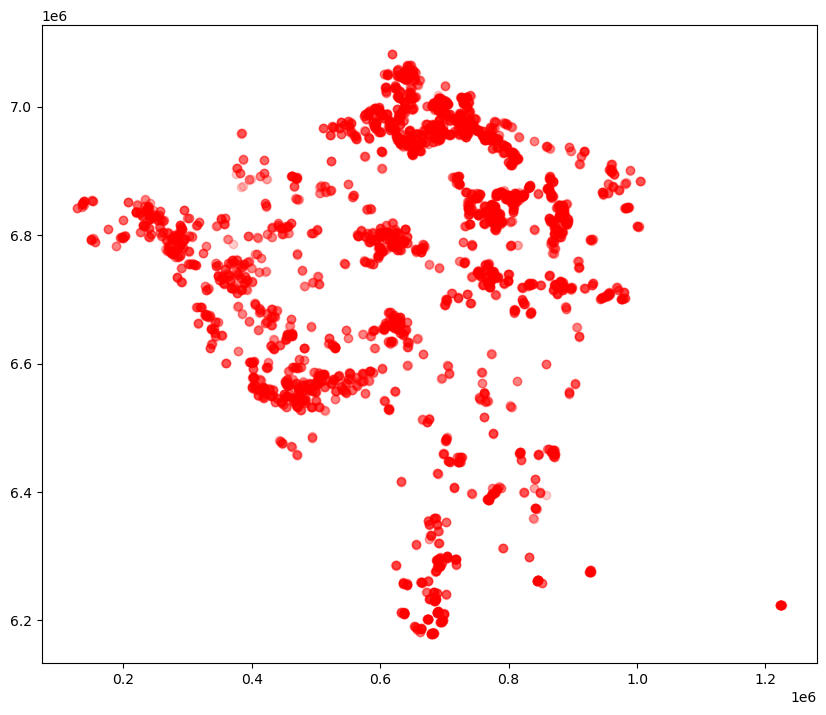

In [14]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

On va désormais afficher une carte de France pour afficher les éoliennes sur la carte 

On utilise le paquet Cartiflette 

In [15]:
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.11
    Uninstalling urllib3-1.26.11:
      Successfully uninstalled urllib3-1.26.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.23.26 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.22 which is incompatible.
boto3 1.26.13 requires botocore<1.30.0,>=1.29.13, but you have botocore 1.23.26 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 2

In [17]:
from cartiflette.download import get_vectorfile_ign

In [18]:
france = get_vectorfile_ign(
    field="metropole",
    level="REGION",
    year=2022)

https://wxs.ign.fr/x02uy2aiwjo9bm8ce5plwqmr/telechargement/prepackage/ADMINEXPRESS_SHP_WGS84G_PACK_2022-06-21$ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21/file/ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21.7z


Downloading: : 563MiB [01:51, 5.29MiB/s] 
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


In [19]:
france = france[0:13] #On retire les outre-mers de la carte
france.head()

,ID,NOM_M,NOM,INSEE_REG,geometry
0,REGION_FXX_0000000000001,ILE-DE-FRANCE,Île-de-France,11,"POLYGON ((2.85612 49.07009, 2.85616 49.07011, ..."
1,REGION_FXX_0000000000002,CENTRE-VAL DE LOIRE,Centre-Val de Loire,24,"POLYGON ((1.70924 48.57802, 1.70934 48.57801, ..."
2,REGION_FXX_0000000000003,BOURGOGNE-FRANCHE-COMTE,Bourgogne-Franche-Comté,27,"POLYGON ((5.40561 47.64813, 5.40490 47.64851, ..."
3,REGION_FXX_0000000000004,NORMANDIE,Normandie,28,"MULTIPOLYGON (((-1.51486 48.66017, -1.51483 48..."
4,REGION_FXX_0000000000005,HAUTS-DE-FRANCE,Hauts-de-France,32,"POLYGON ((2.80921 49.09753, 2.80762 49.09682, ..."


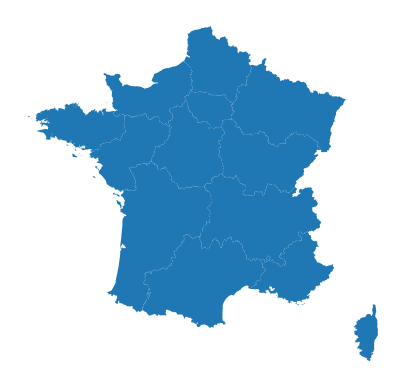

In [20]:
ax = france.plot()
ax.set_axis_off()

Désormais, nous allons rajouter les éoliennes sur notre carte de France

<AxesSubplot: >

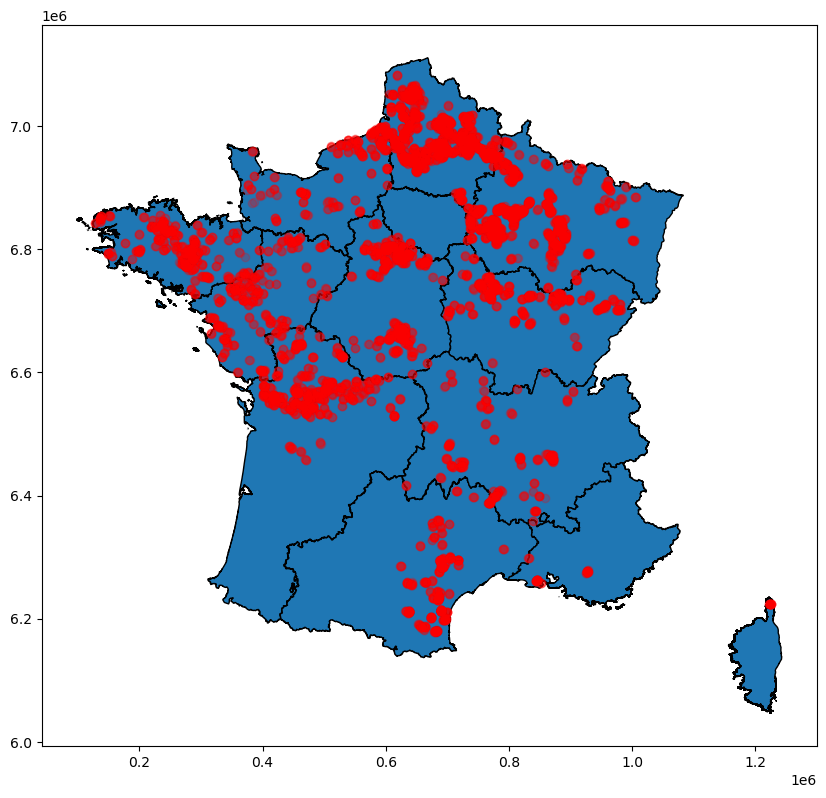

In [21]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")

On rajoute de l'interactivité

In [22]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Voici toutes les éoliennes pour lesquelles nous ne possédons pas les dates d'installations (3152 éoliennes soit 42% des éoliennes que nous avons affiché jusqu'ici) :

<AxesSubplot: >

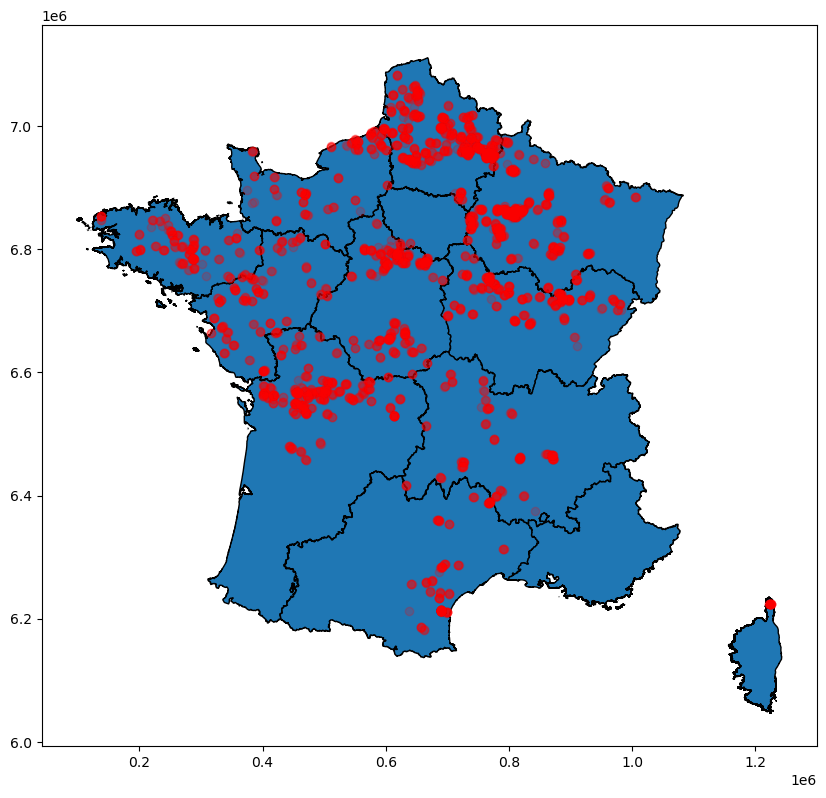

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

Pour celles dont nous connaissons la date, nous affichons ici l'évolution du parc d'éolienne en fonction du temps

In [24]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))



from ipywidgets import interact


def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)   
    
interact(signal_plot,
            annee=periode)
            


interactive(children=(Dropdown(description='annee', options=(Timestamp('2010-12-31 00:00:00'), Timestamp('2011…

<function __main__.signal_plot(annee)>

En affichant celle dont on ne connait pas date d'installation en vert on n'obtient ce graphique :

In [25]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))



from ipywidgets import interact


def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'green', alpha = 0.2, zorder=2)  
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)  

interact(signal_plot,
            annee=periode)

interactive(children=(Dropdown(description='annee', options=(Timestamp('2010-12-31 00:00:00'), Timestamp('2011…

<function __main__.signal_plot(annee)>